# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [41]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.321799
sanity check: 2.302585


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

$\color{blue}{\textit Your Answer:}$ 

- Because we have ten classes, the probability of a random guess is correct is 1/10, so the expected loss is close to -log(0.1) as our W is random genereted and not trained for a single batch



In [50]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -0.742270 analytic: -0.742270, relative error: 5.052800e-08
numerical: -0.128980 analytic: -0.128980, relative error: 2.704444e-07
numerical: -1.521775 analytic: -1.521775, relative error: 7.454743e-09
numerical: 0.611820 analytic: 0.611820, relative error: 2.980631e-08
numerical: 1.658467 analytic: 1.658467, relative error: 1.568928e-08
numerical: -1.042198 analytic: -1.042198, relative error: 1.698285e-08
numerical: -0.132542 analytic: -0.132542, relative error: 2.198882e-07
numerical: 2.978975 analytic: 2.978975, relative error: 2.201444e-08
numerical: 0.134219 analytic: 0.134219, relative error: 5.412030e-08
numerical: 2.560842 analytic: 2.560842, relative error: 6.222006e-09
numerical: 0.866815 analytic: 0.866815, relative error: 3.248587e-08
numerical: 1.017180 analytic: 1.017180, relative error: 9.681837e-08
numerical: -0.670211 analytic: -0.670211, relative error: 8.385727e-08
numerical: 0.369529 analytic: 0.369529, relative error: 1.422787e-07
numerical: -1.992638 a

In [54]:
np.array([1]*3073).shape

(3073,)

In [57]:
W+np.array([1]*3073).reshape(-1,1)

array([[0.99991443, 0.99997067, 0.9999759 , ..., 1.00001261, 0.99981327,
        0.99988947],
       [1.00002331, 0.99987296, 0.99999029, ..., 0.9998465 , 0.9998393 ,
        1.00001163],
       [0.99995854, 1.00007891, 0.99995442, ..., 0.99991377, 0.99994684,
        1.00010414],
       ...,
       [0.99991266, 0.99990805, 1.00000455, ..., 1.00019717, 1.00008601,
        0.99975269],
       [1.00003282, 1.00003609, 1.0001289 , ..., 0.99997879, 1.00003815,
        0.99981093],
       [1.00001265, 0.9999499 , 1.00003235, ..., 1.00004364, 0.99992855,
        0.99998743]])

In [61]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.321799e+00 computed in 0.121675s
vectorized loss: 2.321799e+00 computed in 0.010999s
Loss difference: 0.000000
Gradient difference: 0.000000


In [68]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 2e-7]
regularization_strengths = [1e4, 2e4]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for alpha in learning_rates:
    for lamba in regularization_strengths:
        softmax = Softmax()
        _ = softmax.train(X_train, y_train, learning_rate=alpha, reg=lamba,
                              num_iters=2000, verbose=True)
        y_train_pred = softmax.predict(X_train)
        y_val_pred = softmax.predict(X_val)
        val_acc = np.mean(y_val == y_val_pred)
        results[(alpha, lamba)] = np.mean(y_train == y_train_pred), val_acc
        if best_val < val_acc:
            best_softmax = softmax
            best_val = val_acc

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 2000: loss 317.683328
iteration 100 / 2000: loss 210.910703
iteration 200 / 2000: loss 141.767388
iteration 300 / 2000: loss 95.337554
iteration 400 / 2000: loss 64.529865
iteration 500 / 2000: loss 43.577381
iteration 600 / 2000: loss 29.810091
iteration 700 / 2000: loss 20.664326
iteration 800 / 2000: loss 14.469404
iteration 900 / 2000: loss 10.312255
iteration 1000 / 2000: loss 7.630919
iteration 1100 / 2000: loss 5.801497
iteration 1200 / 2000: loss 4.562203
iteration 1300 / 2000: loss 3.666296
iteration 1400 / 2000: loss 3.106244
iteration 1500 / 2000: loss 2.760740
iteration 1600 / 2000: loss 2.500543
iteration 1700 / 2000: loss 2.328429
iteration 1800 / 2000: loss 2.245036
iteration 1900 / 2000: loss 2.147341
iteration 0 / 2000: loss 618.507807
iteration 100 / 2000: loss 277.239420
iteration 200 / 2000: loss 124.981201
iteration 300 / 2000: loss 57.099382
iteration 400 / 2000: loss 26.679886
iteration 500 / 2000: loss 13.117323
iteration 600 / 2000: loss 6.957850


In [69]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.360000


**Inline Question 2** - *True or False*

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

$\color{blue}{\textit Your Answer:}$

- True

$\color{blue}{\textit Your Explanation:}$

- For linear SVM loss, it is possible when the new datapoint is perfectly classified by our model that the correct class score is higher than all other classes by a number bigger than 1, in which case the loss will be exactly 0

- For linear Softmax loss, it is not possible because the loss can never be exactly zero because exponential can not output zero and in consequence $h = \frac{\exp{f_i}}{\sum{\exp{f_j}}}$ can never be exactly 1 so the loss $-\log(h)$ can never be exactly zero


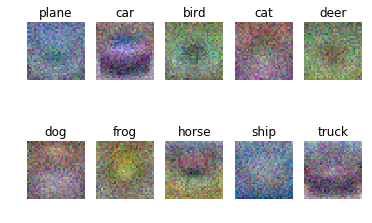

In [67]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])